In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
import shap

In [2]:
pitcher_full_df = pd.read_csv("Resources/full_pitcher_data.csv")
pitcher_era_df = pd.read_csv("Resources/full_era_learning.csv")
pitcher_fip_df = pd.read_csv("Resources/full_fip_learning.csv")
pitcher_whip_df = pd.read_csv("Resources/full_whip_learning.csv")

In [3]:
# Import the necessary libraries
from sklearn.impute import SimpleImputer

# Define the imputer with the strategy you want to use (median, mean, etc.)
imputer = SimpleImputer(strategy='median')

# Columns with NaN values in each DataFrame
columns_with_nans_era = pitcher_era_df.columns[pitcher_era_df.isna().any()].tolist()
columns_with_nans_fip = pitcher_fip_df.columns[pitcher_fip_df.isna().any()].tolist()
columns_with_nans_whip = pitcher_whip_df.columns[pitcher_whip_df.isna().any()].tolist()

# Apply the imputation to each DataFrame
pitcher_era_df[columns_with_nans_era] = imputer.fit_transform(pitcher_era_df[columns_with_nans_era])
pitcher_fip_df[columns_with_nans_fip] = imputer.fit_transform(pitcher_fip_df[columns_with_nans_fip])
pitcher_whip_df[columns_with_nans_whip] = imputer.fit_transform(pitcher_whip_df[columns_with_nans_whip])

In [4]:
pitcher_era_df = pitcher_era_df.drop(['Season','Team','Age Rng','z_score_era_avg', 'z_score_fip_avg', 'z_score_whip_avg', 'z_score_era_2023', 'z_score_fip_2023','z_score_whip_2023'], axis=1)
pitcher_fip_df = pitcher_fip_df.drop(['Season','Team','Age Rng','z_score_era_avg', 'z_score_fip_avg', 'z_score_whip_avg', 'z_score_era_2023', 'z_score_fip_2023','z_score_whip_2023'], axis=1)
pitcher_whip_df = pitcher_whip_df.drop(['Season','Team','Age Rng','z_score_era_avg', 'z_score_fip_avg', 'z_score_whip_avg', 'z_score_era_2023', 'z_score_fip_2023','z_score_whip_2023'], axis=1)

In [5]:
def train_and_evaluate_logistic_regression(df, target_column, solver='lbfgs', max_iter=100):
    
    # Convert the target column into binary classes (0 or 1)
    df[target_column] = df[target_column].apply(lambda x: 1 if x > 0 else 0)
    
    # Split data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Standardize features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    # Create the Logistic Regression model
    logreg_model = LogisticRegression(solver=solver, max_iter=max_iter)
    
    # Train the model
    logreg_model.fit(X_train_scaled, y_train_resampled)
    
    # Make predictions
    y_pred = logreg_model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred)
    
    # Create the SHAP explainer with the trained model
    explainer = shap.Explainer(logreg_model, X_train_scaled)
    
    return {
        "accuracy": accuracy,
        "classification_report": class_report,
        "shap_values": explainer(X_test_scaled),
        "X_test_scaled": X_test_scaled,
        "X_train": X_train_resampled,
        "X_train_scaled": X_train_scaled
    }

In [6]:
pitcher_era_df

,Age,W,L,ERA,G,GS,CG,ShO,SV,BS,...,wNetPitV,TG,wOBA,OBP,SLG,wSB,ERA_avg,FIP_avg,WHIP_avg,z_score_diff_era
0,39,1,12,5.530121,22,22,0,0,0,0,...,0.221085,132,0.0,0.0,0.0,0.0,3.381562,3.780352,1.121997,0.553782
1,35,11,4,2.515528,19,19,0,0,0,0,...,-0.263970,129,0.0,0.0,0.0,0.0,2.902238,3.155674,1.012831,-0.120401
2,41,3,9,8.612070,17,17,0,0,0,0,...,-0.299898,131,0.0,0.0,0.0,0.0,3.854966,3.989132,1.307504,1.247842
3,37,2,6,6.264000,9,9,0,0,0,0,...,0.000000,131,0.0,0.0,0.0,0.0,4.213119,3.648284,1.298954,0.510974
4,36,6,9,6.467967,21,21,0,0,0,0,...,0.262619,131,0.0,0.0,0.0,0.0,4.011502,3.463603,1.283427,0.624339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,24,0,1,135.000141,1,1,0,0,0,0,...,0.000000,162,0.0,0.0,0.0,0.0,4.271903,4.204399,1.308840,0.041355
838,23,0,1,5.400000,1,1,0,0,0,0,...,0.000000,162,0.0,0.0,0.0,0.0,4.271903,4.204399,1.308840,0.041355
839,24,0,0,11.117641,2,2,0,0,0,0,...,0.000000,162,0.0,0.0,0.0,0.0,4.271903,4.204399,1.308840,0.041355
840,25,1,1,3.441176,7,7,0,0,0,0,...,0.000000,161,0.0,0.0,0.0,0.0,4.271903,4.204399,1.308840,0.041355


In [7]:
target_column = 'z_score_diff_era'
result_era = train_and_evaluate_logistic_regression(pitcher_era_df, target_column,  solver='lbfgs', max_iter=200)

# Calculate Accuracy
#rmse = result_era['rmse']
accuracy = result_era['accuracy']
shap_values = result_era['shap_values']


print(f"Accuracy: {result_era['accuracy']:.2f}")

Accuracy: 0.89


In [8]:
target_column = 'z_score_diff_fip'
result_fip = train_and_evaluate_logistic_regression(pitcher_fip_df, target_column,  solver='lbfgs', max_iter=200)

# Access the results
print(f"Accuracy: {result_fip['accuracy']:.2f}")

Accuracy: 0.87


In [9]:
target_column = 'z_score_diff_whip'
result_whip = train_and_evaluate_logistic_regression(pitcher_whip_df, target_column,  solver='lbfgs', max_iter=200)

# Access the results
print(f"Accuracy: {result_whip['accuracy']:.2f}")

Accuracy: 0.89


In [10]:
def train_and_evaluate_classification_model(df, target_column):
    # Drop rows with missing values
    df.dropna(axis=1, inplace=True)
    
    # Convert the target column into binary classes (0 or 1)
    df[target_column] = df[target_column].apply(lambda x: 1 if x > 0 else 0)
    
    # Split data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define cross-validation strategy
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Build the pipeline
    imb_pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgbclassifier', xgb.XGBClassifier(
            max_depth=5,
            learning_rate=0.01,
            n_estimators=600,
            subsample=0.5,
            colsample_bytree=0.25,
            objective='binary:logistic',
            random_state=42
        ))
    ])
    
    # Cross-validate the pipeline
    cross_val_scores = cross_val_score(imb_pipeline, X_train_scaled, y_train, scoring='accuracy', cv=kf)
    
    # Train the pipeline on the training data
    imb_pipeline.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    y_pred = imb_pipeline.predict(X_test_scaled)
    
    # Create the SHAP explainer
    final_estimator = imb_pipeline.named_steps['xgbclassifier']
    explainer = shap.Explainer(final_estimator, X_train_scaled)
    
    # Calculate SHAP values
    shap_values = explainer(X_test_scaled, check_additivity=False)
    
    # Calculate evaluation metrics
    balanced_recall = balanced_accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return {
        "cross_val_scores": cross_val_scores,
        "accuracy": accuracy,
        "balanced_recall": balanced_recall,
        "shap_values": shap_values,
        "X_test_scaled": X_test_scaled,
        "X_train": X_train,
        "X_train_scaled": X_train_scaled,
        "y_pred": y_pred,
        "y_test": y_test,
        "y_train": y_train,
        "X_test": X_test
    }

In [11]:
def create_predictions_dataframe(result_df, name_df):
    y_pred_train = result_df['y_train']
    y_pred_test = result_df['y_pred']
    y_train = result_df['y_train']
    y_test = result_df['y_test']
    
    indexes_train = result_df['X_train'].index
    indexes_test = result_df['X_test'].index
    
    names_train = name_df.loc[indexes_train, 'Name']
    predictions_with_names_train = list(zip(names_train, y_pred_train, y_train))
    
    names_test = name_df.loc[indexes_test, 'Name']
    predictions_with_names_test = list(zip(names_test, y_pred_test, y_test))
    
    predictions_df_train = pd.DataFrame(predictions_with_names_train, columns=['Name', 'Prediction', 'Actual'])
    predictions_df_test = pd.DataFrame(predictions_with_names_test, columns=['Name', 'Prediction', 'Actual'])
    
    # Add a column for correctness
    predictions_df_train['Correctness'] = np.where(predictions_df_train['Prediction'] == predictions_df_train['Actual'], 'Correct :)', 'Wrong :(')
    predictions_df_test['Correctness'] = np.where(predictions_df_test['Prediction'] == predictions_df_test['Actual'], 'Correct :)', 'Wrong :(')
    
    pred_actual_df = pd.concat([predictions_df_train, predictions_df_test], ignore_index=True)
    
    return pred_actual_df

In [12]:
result_era = train_and_evaluate_classification_model(pitcher_era_df, 'z_score_diff_era')

# Print the results
print(f"Cross Value Scores: {result_era ['cross_val_scores']}")
print(f"Accuracy: {result_era ['accuracy']:.2f}")
print(f"Recall: {result_era ['balanced_recall']:.2f}")

Cross Value Scores: [0.94814815 0.93333333 0.94814815 0.95522388 0.99253731]
Accuracy: 0.93
Recall: 0.93


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


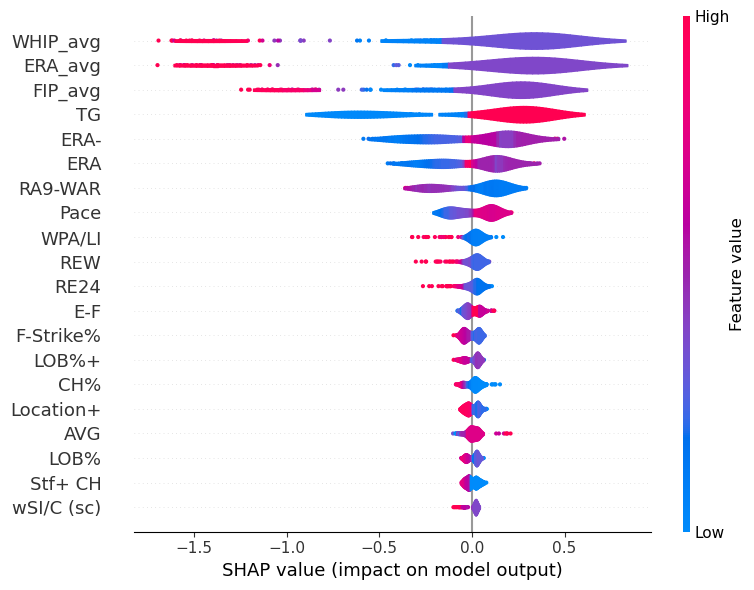

In [13]:
# Generate SHAP summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(result_era['shap_values'], result_era['X_test_scaled'], plot_type='violin', feature_names=result_era['X_train'].columns, show=False)
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_era_class.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [14]:
pred_actual_era = create_predictions_dataframe(result_era, pitcher_full_df)

new_columns = {
    "Prediction": "ERA_Prediction",
    "Actual": "ERA_Actual",
    "Correctness": "ERA_Correctness"
}

pred_actual_era= pred_actual_era.rename(columns=new_columns)

In [15]:
result_fip = train_and_evaluate_classification_model(pitcher_fip_df, 'z_score_diff_fip')

# Print the results
print(f"Cross Value Scores: {result_fip ['cross_val_scores']}")
print(f"Accuracy: {result_fip ['accuracy']:.2f}")
print(f"Recall: {result_fip ['balanced_recall']:.2f}")

Cross Value Scores: [0.93333333 0.94074074 0.96296296 0.95522388 0.97761194]
Accuracy: 0.95
Recall: 0.95


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


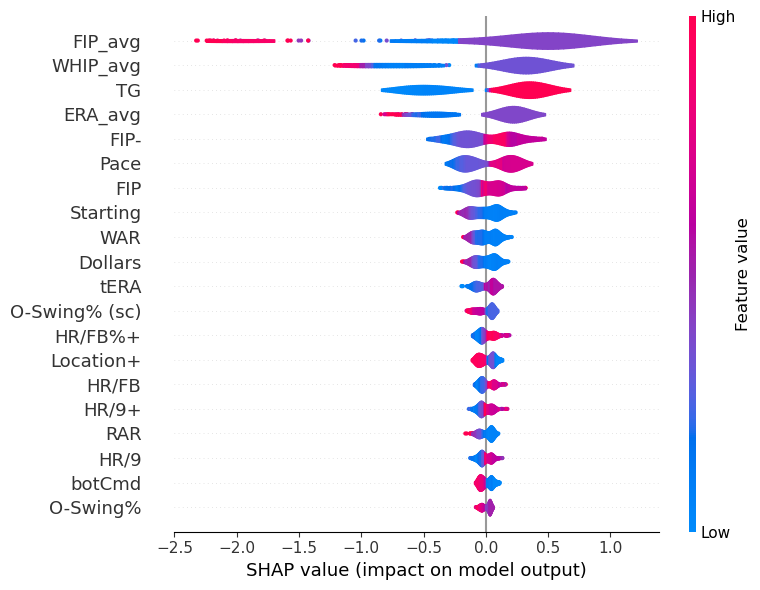

In [16]:
# Generate SHAP summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(result_fip['shap_values'], result_fip['X_test_scaled'], plot_type='violin', feature_names=result_fip['X_train'].columns, show=False)
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_fip_class.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [17]:
pred_actual_fip = create_predictions_dataframe(result_fip, pitcher_full_df)

new_columns = {
    "Prediction": "FIP_Prediction",
    "Actual": "FIP_Actual",
    "Correctness": "FIP_Correctness"
}

pred_actual_fip= pred_actual_fip.rename(columns=new_columns)

In [18]:
result_whip = train_and_evaluate_classification_model(pitcher_whip_df, 'z_score_diff_whip')

# Print the results
print(f"Cross Value Scores: {result_whip ['cross_val_scores']}")
print(f"Accuracy: {result_whip ['accuracy']:.2f}")
print(f"Recall: {result_whip ['balanced_recall']:.2f}")

Cross Value Scores: [0.92592593 0.95555556 0.96296296 0.94029851 0.97761194]
Accuracy: 0.92
Recall: 0.89


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


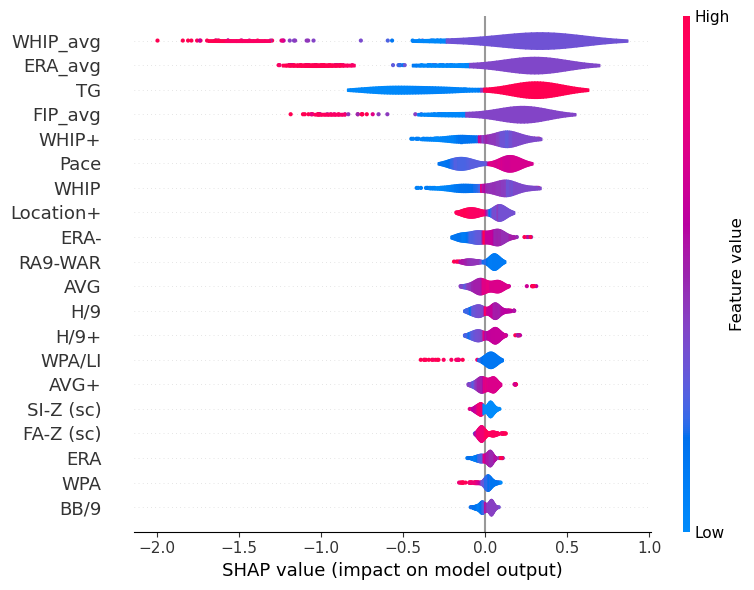

In [19]:
# Generate SHAP summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(result_whip['shap_values'], result_whip['X_test_scaled'], plot_type='violin', feature_names=result_whip['X_train'].columns, show=False)
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_whip_class.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [20]:
pred_actual_whip = create_predictions_dataframe(result_whip, pitcher_full_df)

new_columns = {
    "Prediction": "WHIP_Prediction",
    "Actual": "WHIP_Actual",
    "Correctness": "WHIP_Correctness"
}

pred_actual_whip= pred_actual_whip.rename(columns=new_columns)

In [21]:
# Merge the DataFrames on the "Name" column
merged_df = pd.merge(pred_actual_era, pred_actual_fip, on="Name")
merged_df = pd.merge(merged_df,  pred_actual_whip, on="Name")

pitching_verdict_df = merged_df.drop(["ERA_Prediction", "ERA_Actual", "FIP_Prediction", "FIP_Actual",
                             "WHIP_Prediction", "WHIP_Actual"], axis=1)

pitching_verdict_df.head()

,Name,ERA_Correctness,FIP_Correctness,WHIP_Correctness
0,Jonathan Heasley,Correct :),Correct :),Correct :)
1,Chris Volstad,Correct :),Correct :),Correct :)
2,Robert Gsellman,Correct :),Correct :),Correct :)
3,Angel Zerpa,Correct :),Correct :),Correct :)
4,Aníbal Sánchez,Correct :),Correct :),Correct :)


In [23]:
pitching_verdict_df.to_csv('Resources/pitching_verdict.csv', index=False)